# 태양광 발전소 발전량 예측 (LSTM, Transformer(encoder-only))

[Notion |  https://www.notion.so/ryudoyeon/PV_Plant-Power-26561f7ccc3f802d875af29b7a099e65?source=copy_link]

## 1. Object Setting

> **LSTM**과 **Transforme**r를 멀티 모델로 구현  
> 결과: 한 station의 power 혹은 모든 station의 각각의 power  
> 멀티 모델로 여러 station을 모두 학습하여 결과 냄  
> 두 모델의 성능 비교 (Transformer)가 우세하도록….  

목표

- 태양광 발전소의 발전량(power)을 NWP + LMD 기상 데이터와 meta 데이터를 활용해 예측
- 글로벌 모델: 여러 발전소를 동시에 학습해 공통 패턴 + 개별 특성을 함께 반영
- 시계열 데이터: 15분 단위 **2018년 08월 15일 16:00:00 - 2019년 06월 13일 15:45:00**

In [1]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import math
from torch.utils.data import DataLoader

from models.PVPlant_LSTM import PVPlantLSTM
from models.PVPlant_Transformer import PVPlantTransformer

from utils.test import evaluate, metrics
from utils.train import _to_device, SeqDataset, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2. Data Curation & 3. Data Inspection

### metadata

1. 열 설명
    - Station_ID: 발전소의 고유 식별자   
    - Capacity: 발전소의 설치 용량 (태양광 시스템이 최대 출력할 수 있는 정격 전력)   
    - PV_Technology: 사용된 태양광 패널 기술 종류   
    - Panel_Size: 태양광 모듈 1장의 크기
    - Module: 사용된 태양광 모듈의 모델명 또는 제조사
    - Inverters: 사용된 인버터 종류 및 개수
    - Layout: 패널 배치 방식
    - Panel_Number: 설치된 패널의 총 개수
    - Array_Tilt: 패널의 기울기 각도
    - Pyranometer: 설치 여부 또는 모델명
    - Longtitude: 발전소 경도 좌표
    - Latitude: 발전소 위도 좌표

2. 각 열 시각화
    - 수치형 / 범주형 변수 존재
    - Preprocessing에서 임베딩 필요
    - 위/경도 - 지도 시각화
        - 스케일링 or 지역 군집화
        - 비슷한 중국 지역 밀집도 확인
3. 이상치, 결측치 확인
    - 건물 특성 정보 데이터라 10행
    - 이상치 / 결측치 존재하지 않음

In [2]:
metadata = pd.read_csv("PVODdatasets_v1.0/metadata.csv")
metadata

,Station_ID,Capacity,PV_Technology,Panel_Size,Module,Inverters,Layout,Panel_Number,Array_Tilt,Pyranometer,Longitude,Latitude
0,station00,6600,Poly-Si,1.62360,products types:LW255(29)P1640×990\nPmax:255 Wp...,products types:NSG-500K3TL\nMax. DC input:560 ...,modules per string:20\nstrings per inverter:96,26000,South 33°,GHI: \nproducts types: TBQ-2\nmeasurement accu...,114.951390,38.047780
1,station01,20000,Poly-Si,1.66350,products types:LW6P60-270\nPmax:270 Wp\nVmpp:3...,products types:TC500KH\nMax. DC input:618 kW\n...,modules per string:22\nstrings per inverter:128,74000,South 33°,GHI: \nproducts types: TBQ-2\nmeasurement accu...,117.457220,38.183060
2,station02,17000,Mono-Si,1.63680,products types:RSM60-6-285M\nPmax:285 Wp\nVmpp...,products types:SG50KTL-M\nMax. DC input:-\nMax...,modules per string:22\nstrings per inverter:8,64064,South 29°,GHI: \nproducts types: TBQ-2\nmeasurement accu...,114.198870,38.057280
3,station03,20000,Poly-Si,1.62000,products types:HTMP265P4-60\nPmax:265 Wp\nVmpp...,products types:PVL-L1000E\nMax. DC input:-\nMa...,modules per string:22\nstrings per inverter:16,75460,South 33°,GHI: \nproducts types: TBQ-2L\nmeasurement acc...,114.114940,38.109560
4,station04,20000,Poly-Si,1.63680,products types:YL265P-29b\nPmax:265 Wp\nVmpp:3...,products types:SG1000\nMax. DC input:560 kW\nM...,modules per string:22\nstrings per inverter:86,75680,South 37°,GHI: \nproducts types: TBQ-2\nmeasurement accu...,114.867670,39.515500
5,station05,35000,Poly-Si,1.63515,products types:LR6-60-305M\nPmax:305 Wp\nVmpp:...,products types:SG1250UD\nMax. DC input:618 kW\...,modules per string:22\nstrings per inverter:160,114972,South 33°,GHI: \nproducts types: TBQ-2\nmeasurement accu...,114.123600,38.235500
6,station06,15000,Poly-Si,1.63350,products types:JAP60S01-270/SC\nPmax:270 Wp\nV...,products types:SG50KTL-M\nMax. DC input:-\nMax...,modules per string:24\nstrings per inverter:8,56608,South 34°,GHI: \nproducts types: TBQ-2\nmeasurement accu...,114.548410,36.898910
7,station07,20000,Poly-Si,1.63350,products types:YL250P-29b\nPmax:250 Wp\nVmpp:2...,products types:TC500KH\nMax. DC input:618 kW\n...,modules per string:20\nstrings per inverter:100,80000,South 31°,GHI: \nproducts types: TBQ-2L\nmeasurement acc...,113.641870,36.644030
8,station08,20000,Poly-Si,1.63350,products types:YL265C-30b\nPmax:265 Wp\nVmpp:3...,products types:SUN2000-40KTL\nMax. DC input: 4...,modules per string:22\nstrings per inverter:5,78042,South 33°,GHI: \nproducts types: TBQ-2\nmeasurement accu...,113.899990,36.707610
9,station09,20000,Poly-Si,1.61370,products types:YL265P-29B-265W\nPmax:265 Wp\nV...,products types:GSL0630T\nMax. DC input:690 kW\...,modules per string:24\nstrings per inverter:128,84480,South 31°,GHI: \nproducts types: TBQ-2\nmeasurement accu...,115.059855,38.731417


1. 열 목록

In [3]:
metadata.columns

Index(['Station_ID', 'Capacity', 'PV_Technology', 'Panel_Size', 'Module',
       'Inverters', 'Layout', 'Panel_Number', 'Array_Tilt', 'Pyranometer',
       'Longitude', 'Latitude'],
      dtype='object')

2. 각 열 시각화

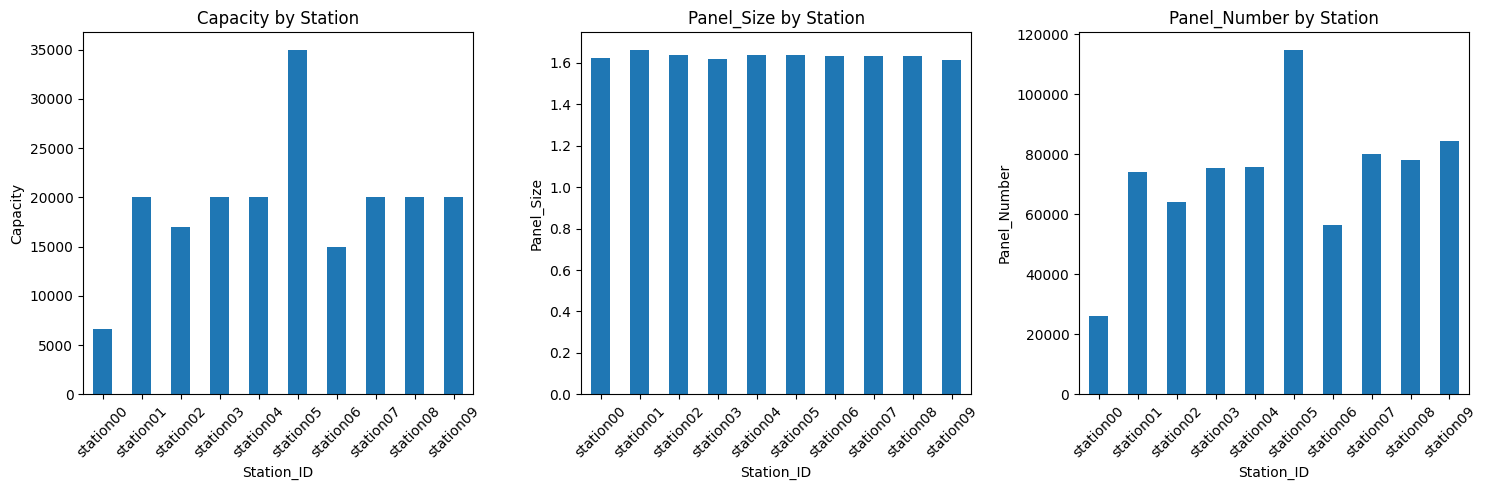

In [4]:
# (1) 수치형 열 Bar chart

num_cols = ['Capacity', 'Panel_Size', 'Panel_Number']
stations = metadata['Station_ID'].nunique()

# subplot 크기 정의
fig, axes = plt.subplots(1, len(num_cols), figsize=(5*len(num_cols), 5))

for i, col in enumerate(num_cols):
    ax = axes[i]
    values = metadata.groupby('Station_ID')[col].mean()
    values.plot(kind='bar', ax=ax)
    ax.set_title(f'{col} by Station')
    ax.set_xlabel('Station_ID')
    ax.set_ylabel(col)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [5]:
# (2) 범주형 열 개수, 빈도수 파악
cat_cols = ['PV_Technology', 'Inverters', 'Array_Tilt', 'Pyranometer']

for col in cat_cols:
    print(f"Column: {col}")
    print(metadata[col].value_counts())
    print("\n")

# Module, Layout: 10개가 모두 다름 - 학습 시 제외함
# 나머지는 추후 인코딩 or 임베딩 계획

Column: PV_Technology
PV_Technology
Poly-Si    9
Mono-Si    1
Name: count, dtype: int64


Column: Inverters
Inverters
products types:TC500KH\nMax. DC input:618 kW\nMax. DC voltage: 1000 V\nMax. DC current: 1344 A\nRated power: 500 kW\nmanufacturer:tbeapower                                                   2
products types:SG50KTL-M\nMax. DC input:-\nMax. DC voltage: 1100 V\nMax. DC current: 100 A\nRated power: 55 kW\nmanufacturer:sungrowpower                                                     2
products types:NSG-500K3TL\nMax. DC input:560 kW\nMax. DC voltage: 1000 V\nMax. DC current: 1120 A\nRated power: 500 kW\nmanufacturer:ZOF new energy                                          1
products types:PVL-L1000E\nMax. DC input:-\nMax. DC voltage: 1000 V\nMax. DC current: 1344 A\nRated power: 1000 kW\nmanufacturer:Toshiba Mitsubishi-Electric Industrial System Corporation    1
products types:SG1000\nMax. DC input:560 kW\nMax. DC voltage: 1000 V\nMax. DC current: 1220 A\nRated power: 1000 k

In [6]:
# (3) station 지도 시각화

# 지도 초기화 (중심: 평균 좌표)
m = folium.Map(location=[metadata["Latitude"].mean(), metadata["Longitude"].mean()], zoom_start=7)

# 마커 추가
for _, row in metadata.iterrows():
    folium.Marker(
        location=[row["Latitude"], row["Longitude"]],
        popup=f"Station: {row['Station_ID']}"
    ).add_to(m)

m

3. 이상치 / 결측치 확인
    - 실제 발전소 특성 정보, 10개 밖에 안 됨
    - 이상치 / 결측치 존재하지 않음

In [7]:
# 결측치 확인
print(metadata.isnull().sum())

Station_ID       0
Capacity         0
PV_Technology    0
Panel_Size       0
Module           0
Inverters        0
Layout           0
Panel_Number     0
Array_Tilt       0
Pyranometer      0
Longitude        0
Latitude         0
dtype: int64


### station 데이터

1. 열 설명
    - date_time: timstamp   
**NWP (Numerical Weather Prediction, 수치예보 모델 출력 값)**   
    - nwp_globalirrad: Global Irradiance (태양이 지표면에 도달하는 총 일사량 (W/m2))
    - nwp_directirrad: Direct Irradiance (태양에서 직접 도달하는 일사 성분 (W/m2))
    - nwp_temperature: 기온, NWP에서 예측된 값
    - nwp_humidity: 상대습도, NWP에서 예측된 값
    - nwp_windspeed: 풍속, NWP 예보 값
    - nwp_winddirection: 풍향, NWP 예보 값
    - nwp_pressure: 기압, NWP 예보 값   
**LMD (Local Meteorological Data, 현장 기상 관측 데이터)**   
    - lmd_totalirrad: 총 일사량(Global Irradiance), 현장 측정 값   
    - lmd_diffuseirrad: 산란일사량(Diffuse Irradiance), 구름/대기 산란을 통해 도달하는 성분
    - lmd_temperature: 기온, 현장 기상 센서 측정 값
    - lmd_pressure: 기압, 현장 기상 센서 측정 값
    - lmd_winddirection: 풍향, 현장 측정 값
    - lmd_windspeed: 풍속, 현장 측정 값   
**발전소 성능**   
    - power: 실제 발전소의 전력 출력   

2. 예측값: power
3. 각 기상변수 vs power 시각화
    - 발전소별 데이터 분포 확인
    - 그래프
    - 히트맵 (기상 변수와 발전량 간의 기본 상관 관계 확인)
4. 발전소별 데이터 개수 균형, 운영 기간 체크
5. 이상치, 결측치 확인
    - 평균, 중앙값, 이상치 등등 확인

In [8]:
stations = pd.DataFrame()
for i in range(10):
    df = pd.read_csv(f"PVODdatasets_v1.0/station0{i}.csv")
    df["Station_ID"] = f"station{i:02d}"
    stations = pd.concat([stations, df], ignore_index=True)
# 열 순서 변경 Station_ID 맨 앞으로
stations = stations[["Station_ID"] + [col for col in stations.columns if col != "Station_ID"]]
# Station_ID, date_time으로 정렬
stations = stations.sort_values(by=["Station_ID", "date_time"]).reset_index(drop=True)
stations

,Station_ID,date_time,nwp_globalirrad,nwp_directirrad,nwp_temperature,nwp_humidity,nwp_windspeed,nwp_winddirection,nwp_pressure,lmd_totalirrad,lmd_diffuseirrad,lmd_temperature,lmd_pressure,lmd_winddirection,lmd_windspeed,power
0,station00,2018-08-15 16:00:00,0.0,0.0,22.78,96.85,4.28,339.41,1007.27,0.0,0.0,25.900000,1006.299988,353.0,1.1,0.0
1,station00,2018-08-15 16:15:00,0.0,0.0,22.75,96.91,4.30,337.27,1007.27,0.0,0.0,25.900000,1006.200012,330.0,0.9,0.0
2,station00,2018-08-15 16:30:00,0.0,0.0,22.71,96.95,4.28,334.47,1007.48,0.0,0.0,25.799999,1006.299988,1.0,1.9,0.0
3,station00,2018-08-15 16:45:00,0.0,0.0,22.64,97.12,4.28,331.52,1007.39,0.0,0.0,25.600000,1006.299988,309.0,0.4,0.0
4,station00,2018-08-15 17:00:00,0.0,0.0,22.57,97.15,4.33,329.78,1007.09,0.0,0.0,25.700001,1006.299988,335.0,1.6,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271963,station09,2019-06-13 14:45:00,0.0,0.0,25.60,59.45,2.92,11.18,999.82,0.0,0.0,21.400000,998.299988,111.0,0.0,0.0
271964,station09,2019-06-13 15:00:00,0.0,0.0,25.35,60.53,2.90,4.73,999.92,0.0,0.0,21.299999,998.400024,181.0,0.4,0.0
271965,station09,2019-06-13 15:15:00,0.0,0.0,25.11,61.55,2.95,358.79,1000.01,0.0,0.0,22.400000,998.299988,346.0,0.0,0.0
271966,station09,2019-06-13 15:30:00,0.0,0.0,24.88,62.46,3.03,353.39,1000.12,0.0,0.0,22.000000,998.400024,141.0,0.0,0.0


1. 열 목록

In [9]:
stations.columns

Index(['Station_ID', 'date_time', 'nwp_globalirrad', 'nwp_directirrad',
       'nwp_temperature', 'nwp_humidity', 'nwp_windspeed', 'nwp_winddirection',
       'nwp_pressure', 'lmd_totalirrad', 'lmd_diffuseirrad', 'lmd_temperature',
       'lmd_pressure', 'lmd_winddirection', 'lmd_windspeed', 'power'],
      dtype='object')

2. 예측값: power

- 각 발전소마다 시계열 범위가 다름을 확인
- 글로벌 모델 학습 시 각 발전소마다 가진 데이터 기간만큼 학습하도록 반영

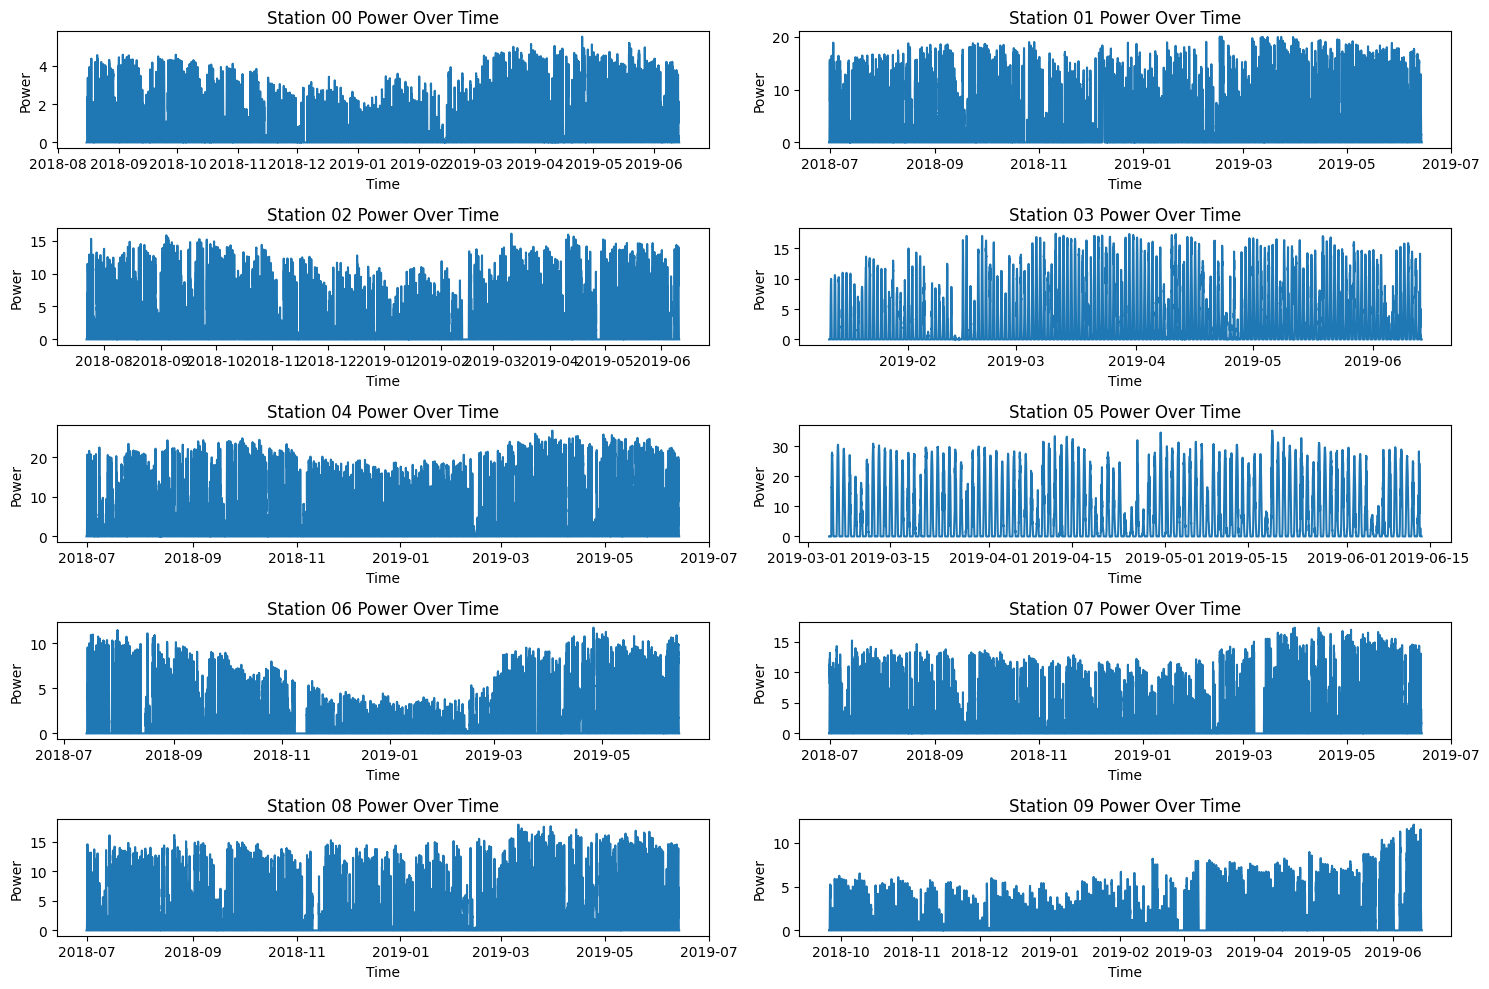

In [10]:
# 각 발전소별 power 시계열 시각화
plt.figure(figsize=(15, 10))
for i in range(10):
    plt.subplot(5, 2, i+1)
    station_data = stations[stations['Station_ID'] == f'station{i:02d}']
    plt.plot(pd.to_datetime(station_data['date_time']), station_data['power'])
    plt.title(f'Station {i:02d} Power Over Time')
    plt.xlabel('Time')
    plt.ylabel('Power')
    plt.tight_layout()

3. 각 기상변수 vs power 시각화

In [11]:
# 각 기상변수 vs power 시각화 # 각 발전소마다 따로 시각화
# 그래프: 발전소 수 x 기상변수 수
weather_cols = [col for col in stations.columns if col not in ['Station_ID', 'date_time', 'power']]
def plot_weather_vs_power(station_id):
    station_data = stations[stations['Station_ID'] == station_id]
    ncols = 3  # 한 줄에 3개씩
    nrows = math.ceil(len(weather_cols) / ncols)
    print(f"Plotting for {station_id}")
    plt.figure(figsize=(6*ncols, 4*nrows))  # 전체 크기 조정
    for j, col in enumerate(weather_cols):
        ax = plt.subplot(nrows, ncols, j + 1)
        ax.scatter(station_data[col], station_data['power'], alpha=0.5)
        ax.set_title(f'{station_id} - {col} vs Power')
        ax.set_xlabel(col)
        ax.set_ylabel('Power')
    # plt.suptitle(f'Weather Variables vs Power for {station_id}', fontsize=16)
    plt.tight_layout()
    plt.show()

In [12]:
# for i in range(10):
#     plot_weather_vs_power(f'station{i:02d}')

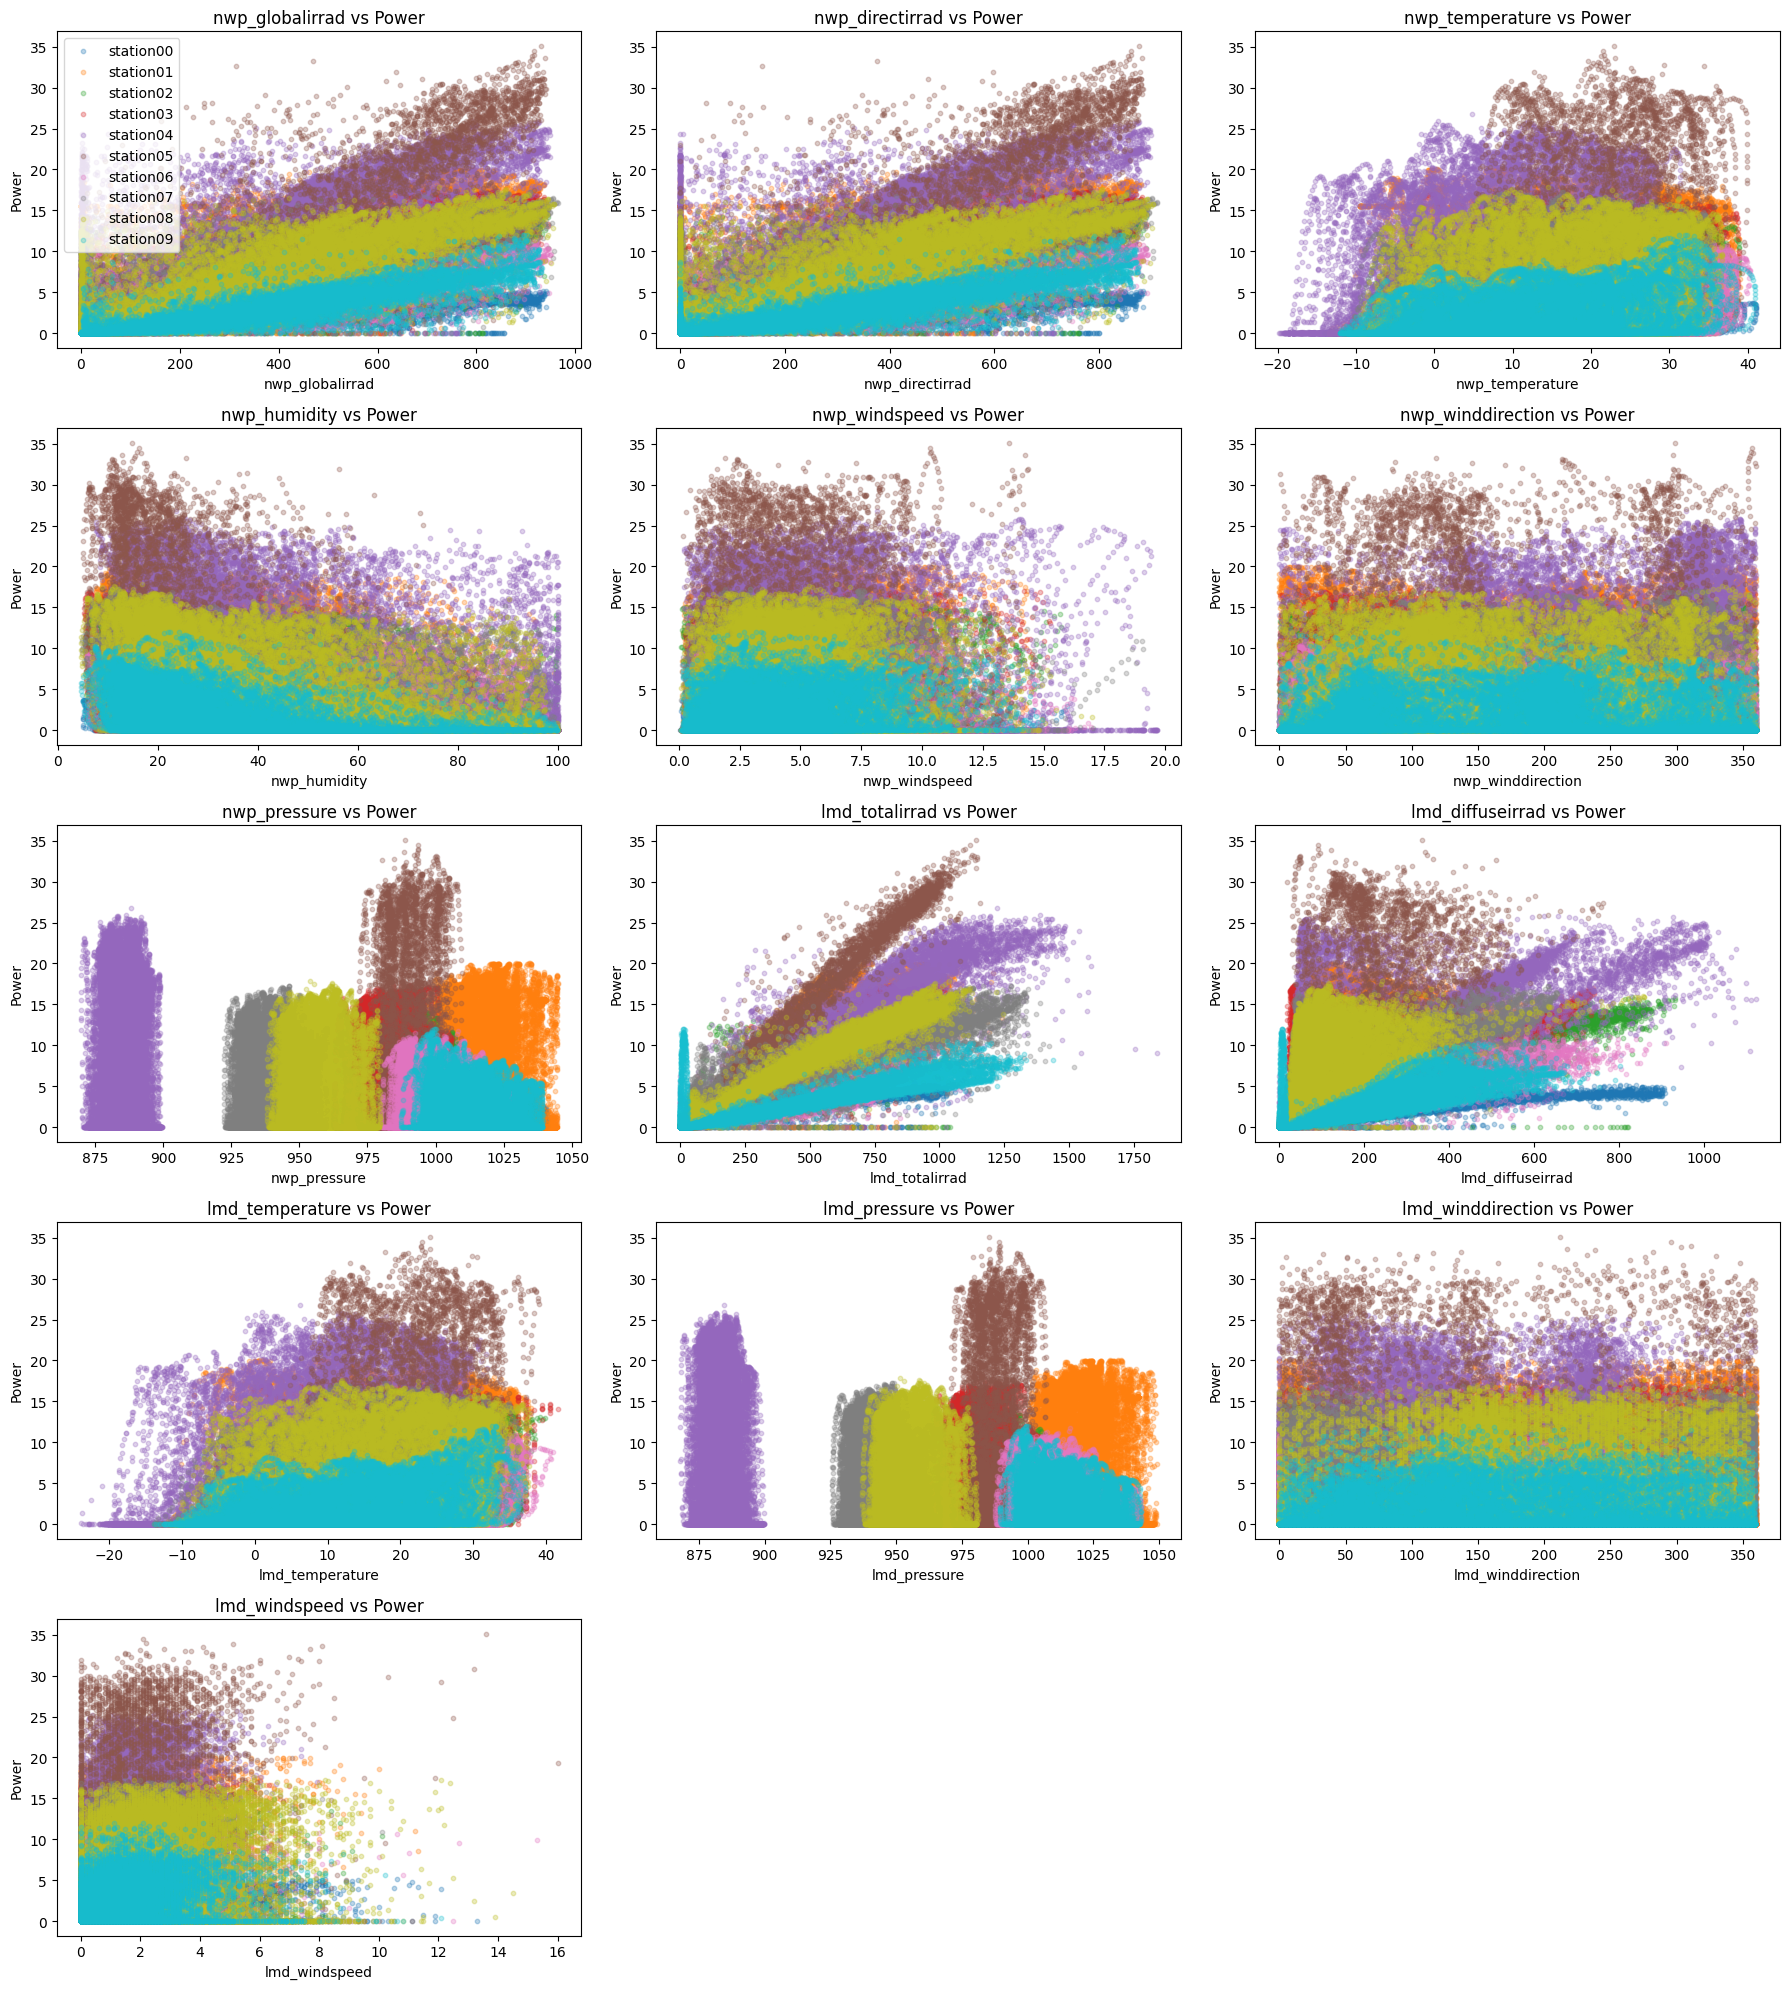

In [13]:
weather_cols = [col for col in stations.columns if col not in ['Station_ID', 'date_time', 'power']]

ncols = 3
nrows = math.ceil(len(weather_cols) / ncols)

plt.figure(figsize=(6*ncols, 4*nrows))

for j, col in enumerate(weather_cols):
    ax = plt.subplot(nrows, ncols, j + 1)
    for sid, group in stations.groupby('Station_ID'):
        ax.scatter(group[col], group['power'], alpha=0.3, label=sid, s=10)
    ax.set_title(f'{col} vs Power')
    ax.set_xlabel(col)
    ax.set_ylabel('Power')
    if j == 0:  # 첫 번째 subplot에만 범례
        ax.legend()

plt.tight_layout()
plt.show()


In [14]:
# # 상관관계 히트맵
# #    기상 변수와 발전량 간의 기본 상관 관계 확인

# # 발전소 ID 목록
# station_ids = sorted(stations['Station_ID'].unique())

# # 발전소별로 상관관계 계산
# for sid in station_ids:
#     station_data = stations[stations['Station_ID'] == sid]
    
#     # 기상변수 + power만 선택
#     corr_df = station_data[weather_cols + ['power']]
    
#     # 상관계수 계산
#     corr_matrix = corr_df.corr()
    
#     # power와의 상관계수만 추출 (행: 변수, 열: power)
#     corr_with_power = corr_matrix[['power']].drop('power')
    
#     # 히트맵 시각화
#     plt.figure(figsize=(6, len(weather_cols)*0.4))
#     sns.heatmap(corr_with_power, annot=True, cmap="coolwarm", center=0)
#     plt.title(f"{sid} - Weather vs Power Correlation")
#     plt.show()

# # 상관 관계가 낮은 변수들도 학습에 포함 - 비선형 관계나 변수 상호작용을 위해서 
# # 그러나 모델 학습 후 Feature importance 확인해서 기여도가 낮을 시 제거
# #    Shapley values / permutation importance / attention score로 변수 기여도 확인

4. 발전소별 데이터 개수 균형, 운영 기간 체크

In [15]:
# 각 발전소별 시계열 데이터 범위 확인
for i in range(10):
    station_data = stations[stations['Station_ID'] == f'station{i:02d}']
    min_date = pd.to_datetime(station_data['date_time']).min()
    max_date = pd.to_datetime(station_data['date_time']).max()
    print(f'Station {i:02d}: {min_date} to {max_date}, Total records: {len(station_data)}')

# 우선, 범위 합집합 모델 학습 예정
# 글로벌 모델 시 각 발전소 시계열 데이터 범위마다 구별, 학습/검증/테스트 분할, 보간 등 전처리 계획

Station 00: 2018-08-15 16:00:00 to 2019-06-13 15:45:00, Total records: 28896
Station 01: 2018-06-30 16:00:00 to 2019-06-13 15:45:00, Total records: 33408
Station 02: 2018-07-22 16:00:00 to 2019-06-10 15:45:00, Total records: 30432
Station 03: 2019-01-11 16:00:00 to 2019-06-13 15:45:00, Total records: 14688
Station 04: 2018-06-30 16:00:00 to 2019-06-13 15:45:00, Total records: 33408
Station 05: 2019-03-04 16:00:00 to 2019-06-13 15:45:00, Total records: 9696
Station 06: 2018-07-13 16:00:00 to 2019-06-13 15:45:00, Total records: 31104
Station 07: 2018-06-30 16:00:00 to 2019-06-13 15:45:00, Total records: 32928
Station 08: 2018-06-30 16:00:00 to 2019-06-13 15:45:00, Total records: 33120
Station 09: 2018-09-25 16:00:00 to 2019-06-13 15:45:00, Total records: 24288


5. 이상치, 결측치 확인

In [16]:
# 각 발전소별 열 결측치 확인
for i in range(10):
    station_data = stations[stations['Station_ID'] == f'station{i:02d}']
    print(f"Station {i:02d} Missing Values:")
    print(station_data.isnull().sum())
    print("\n")


Station 00 Missing Values:
Station_ID           0
date_time            0
nwp_globalirrad      0
nwp_directirrad      0
nwp_temperature      0
nwp_humidity         0
nwp_windspeed        0
nwp_winddirection    0
nwp_pressure         0
lmd_totalirrad       0
lmd_diffuseirrad     0
lmd_temperature      0
lmd_pressure         0
lmd_winddirection    0
lmd_windspeed        0
power                0
dtype: int64


Station 01 Missing Values:
Station_ID           0
date_time            0
nwp_globalirrad      0
nwp_directirrad      0
nwp_temperature      0
nwp_humidity         0
nwp_windspeed        0
nwp_winddirection    0
nwp_pressure         0
lmd_totalirrad       0
lmd_diffuseirrad     0
lmd_temperature      0
lmd_pressure         0
lmd_winddirection    0
lmd_windspeed        0
power                0
dtype: int64


Station 02 Missing Values:
Station_ID           0
date_time            0
nwp_globalirrad      0
nwp_directirrad      0
nwp_temperature      0
nwp_humidity         0
nwp_windspeed  

In [17]:
for i in range(10):
    print(f"Station {i:02d} Descriptive Statistics:")
    print(station_data.describe())
    print("\n")

Station 00 Descriptive Statistics:
       nwp_globalirrad  nwp_directirrad  nwp_temperature  nwp_humidity  \
count     24288.000000     24288.000000     24288.000000  24288.000000   
mean        168.616393       148.487672         9.149694     35.288623   
std         245.244499       224.780828        10.268703     18.067687   
min           0.000000         0.000000       -12.010000      4.640000   
25%           0.000000         0.000000         0.860000     22.040000   
50%           0.000000         0.000000         8.240000     31.760000   
75%         316.267500       271.505000        16.260000     43.710000   
max         931.560000       874.590000        40.980000     99.930000   

       nwp_windspeed  nwp_winddirection  nwp_pressure  lmd_totalirrad  \
count   24288.000000       24288.000000  24288.000000    24288.000000   
mean        3.463507         189.689110   1015.457260      201.963112   
std         2.082610         113.733165      9.919514      323.603158   
min   

In [18]:
# # 각 열별 이상치 Box plot (발전소 다른 색)
# # weather_cols 사용
# for col in weather_cols:
#     plt.figure(figsize=(10, 6))
#     sns.boxplot(x='Station_ID', y=col, data=stations)
#     plt.title(f'Box Plot of {col} by Station')
#     plt.xlabel('Station_ID')
#     plt.ylabel(col)
#     plt.xticks(rotation=45)
#     plt.show()

# # 이상치 처리 계획
# # IQR, Z-score 등 통계적 방법 활용 예정
# # 이상치 큰 변수
# # nwp_globalirrad, nwp_directirrad, nwp_windspeed, nwp_windspeed, lmd_totalirrad, lmd_diffuseirrad, lmd_windspeed

## 4. Data Preprocessing

### Metadata

1. 수치형 변수 → 스케일링
2. 범주형 변수 → one-hot 임베딩
3. 위치 → 스케일링 or 지역 군집화
4. station_id 임베딩

- train/valid/test 분할 필요 없음

In [19]:
# Module, Layout: 10개가 모두 다름 - 학습 시 제외함
metadata = metadata.drop(columns=['Module', 'Layout'])

1. 수치형 변수 -> 스케일링

In [20]:
# 수치형 메타데이터
# num_cols = ['Capacity', 'Panel_Size', 'Panel_Number']
# 이상치 / 결측치 존재하지 않음
# 단순 스케일링만 진행

# Capacity, Panel_Number: StandardScaler # 이상치 존재 가능성 있음
# Panel_Size: MinMaxScaler # 값이 다 비슷함

from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler_std = StandardScaler()
scaler_mm = MinMaxScaler()

for col in ['Capacity', 'Panel_Number']:
    metadata[col] = scaler_std.fit_transform(metadata[[col]])
metadata['Panel_Size'] = scaler_mm.fit_transform(metadata[['Panel_Size']])

In [21]:
# 범주형 메타데이터
# cat_cols = ['PV_Technology', 'Inverters', 'Array_Tilt', 'Pyranometer']
# 데이터가 10개 밖에 안 되므로 전부 원-핫 인코딩

metadata = pd.get_dummies(metadata, columns=cat_cols, drop_first=True)
for col in metadata.columns:
    if metadata[col].dtype == bool:
        metadata[col] = metadata[col].astype(int)

# 스케일링할 숫자만 변환
for col in ['Latitude', 'Longitude']:
    metadata[col] = scaler_mm.fit_transform(metadata[[col]])

metadata 전처리 완료

### station data

1. NWP / LMD / Power 정렬 및 시간 동기화
2. Feature engineering
    - 날짜 관련 정보 추가
3. train / valid / test 분할
    - train
    - valid
    - test
4. 이상치 확인 후 결측치로 변환
5. 결측지 확인 후 보정
    - 보간, 앞 뒤
6. 풍향, 시간 → sin/cos 변환
7. X, y 분할
8. 스케일링
    - train으로만 fit → valid, test transform
9. 타겟 로그 변환 (선택)
10. 슬라이딩 윈도우 생성 
    - input_window:
    - output_window:

1. 발전소별 시계열 데이터 정렬

In [22]:
# 정렬 및 시간 동기화
# 아직은 NWP, LMD, power 모두 함께 수행

def sort_by_station_and_time(df) -> pd.DataFrame:
    """
    Function: sort_by_station_and_time
        - 발전소 ID와 시간에 따라 데이터 정렬 및 중복 제거
    Parameters:
        - df: pd.DataFrame
            - 입력 데이터프레임 (Station_ID, date_time 포함)
    Returns:
        - pd.DataFrame
            - 정렬 및 중복 제거된 데이터프레임
    """
    # date_time을 datetime으로 변환
    df['date_time'] = pd.to_datetime(df['date_time'])
    df = df.sort_values(by=['Station_ID', 'date_time']).drop_duplicates(subset=['Station_ID', 'date_time'])

    result = []
    for sid, group in df.groupby('Station_ID'):
        # 발전소별 15분 간격 타임라인 생성
        all_times = pd.date_range(start=group['date_time'].min(),
                                  end=group['date_time'].max(),
                                  freq='15min')
        # reindex
        group = group.set_index('date_time').reindex(all_times)
        group['Station_ID'] = sid
        group.index.name = 'date_time'
        result.append(group.reset_index())

    return pd.concat(result, ignore_index=True)

stations = sort_by_station_and_time(stations)

2. Feature Engineering
- 날짜 정보 추가하기

In [23]:
# 요일 인코딩 (0: 월요일, 6: 일요일)
stations['day_of_week'] = pd.to_datetime(stations['date_time']).dt.dayofweek
stations["dow_sin"] = np.sin(2 * np.pi * stations['day_of_week'] / 7)
stations["dow_cos"] = np.cos(2 * np.pi * stations['day_of_week'] / 7)

# 주말 인코딩
stations['is_weekend'] = stations['day_of_week'].isin([5, 6]).astype(int)

# 공휴일 인코딩 (중국)
import holidays
cn_holidays = holidays.CountryHoliday('China', years=[2018, 2019])
stations['is_holiday'] = pd.to_datetime(stations['date_time']).dt.date.isin(cn_holidays).astype(int)

# 시간대 인코딩
stations['hour'] = stations['date_time'].dt.hour
stations["hour_sin"] = np.sin(2 * np.pi * stations['hour'] / 24)
stations["hour_cos"] = np.cos(2 * np.pi * stations['hour'] / 24)

# 경계 분할 이후 작업
stations = stations.drop(columns=['day_of_week', 'hour'])

3. train / valid / test 분할

- 모든 경계는 월요일 - 일요일    
- 각 station마다 기간이 다르므로 비율로 환산해서 추출   

과정   
    1. 해당 station의 전체 timestamp 길이 구하기   
    2. train: 길이의 80%, valid: 다음 10%, test: 마지막 10%로 분할   
    3. 이 때, 각 구간의 시작 -> 바로 다음 월요일로 변경    
    4. 각 구간의 마지막 -> 이전 일요일로 변경   
    5. gap: train -7일, valid - 7일로 gap 설정    

In [24]:
# Station 00: 2018-08-15 16:00:00 to 2019-06-13 15:45:00, Total records: 28896
# Station 01: 2018-06-30 16:00:00 to 2019-06-13 15:45:00, Total records: 33408
# Station 02: 2018-07-22 16:00:00 to 2019-06-10 15:45:00, Total records: 30432
# Station 03: 2019-01-11 16:00:00 to 2019-06-13 15:45:00, Total records: 14688
# Station 04: 2018-06-30 16:00:00 to 2019-06-13 15:45:00, Total records: 33408
# Station 05: 2019-03-04 16:00:00 to 2019-06-13 15:45:00, Total records: 9696
# Station 06: 2018-07-13 16:00:00 to 2019-06-13 15:45:00, Total records: 31104
# Station 07: 2018-06-30 16:00:00 to 2019-06-13 15:45:00, Total records: 32928
# Station 08: 2018-06-30 16:00:00 to 2019-06-13 15:45:00, Total records: 33120
# Station 09: 2018-09-25 16:00:00 to 2019-06-13 15:45:00, Total records: 24288

In [25]:
def get_train_valid_test_split_indices(
        df, 
        station_name, 
        train_ratio=0.8, 
        valid_ratio=0.1
    ):
    """
    Function: get_train_valid_test_split_indices
        - 발전소별로 시계열 데이터를 train, valid, test로 분할하는 함수
        - 각 구간의 시작은 월요일 00:00, 끝은 일요일 23:45로 맞춤
        - train, valid 구간 끝에서 각각 7일 간격의 gap 설정
    Parameters:
        - df: pd.DataFrame
            - 입력 데이터프레임 (Station_ID, date_time 포함)
        - station_name: str
            - 발전소 ID (예: 'station00')
        - train_ratio: float
            - 학습 데이터 비율 (기본값: 0.8)
        - valid_ratio: float
            - 검증 데이터 비율 (기본값: 0.1)
    Returns:
        - dict
            - 'train', 'valid', 'test' 구간의 시작과 끝 날짜를 포함하는 딕셔너리
    """
    data = df[df['Station_ID'] == station_name].copy()
    data = data.sort_values(by='date_time').reset_index(drop=True)
    data['date_time'] = pd.to_datetime(data['date_time'])
    
    def next_monday(ts):
        """다음 월요일 00:00 반환"""
        ts = pd.Timestamp(ts)
        base = ts.normalize() # 시간 제거 (00:00)
        return base if base.weekday() == 0 else (base + pd.offsets.Week(weekday=0))

    def prev_sunday(ts):
        """이전 일요일 날짜(00:00)만을 반환"""
        ts = pd.Timestamp(ts)
        base = ts.normalize() # 시간 제거 (00:00) # week_end에서 다시 끝나는 시간 맞출 것.
        return base if base.weekday() == 6 else (base - pd.offsets.Week(weekday=6))

    def week_end(ts):
        """해당 날짜의 주말(일요일 23:45:00) 반환 (15분 주기)"""
        ts = pd.Timestamp(ts)
        return ts + pd.Timedelta(days=(6 - ts.weekday())) + pd.Timedelta(hours=23, minutes=45)

    
    # 1. 비율별로 인덱스 계산
    total_len = len(data)
    train_end_idx = int(total_len * train_ratio)
    valid_end_idx = int(total_len * (train_ratio + valid_ratio))
    test_end_idx = total_len

    # 2. 해당 인덱스로 train, valid, test 구간 설정
    train_start = data.loc[0, 'date_time']
    train_end = data.loc[train_end_idx - 1, 'date_time']
    valid_start = data.loc[train_end_idx, 'date_time']
    valid_end = data.loc[valid_end_idx - 1, 'date_time']
    test_start = data.loc[valid_end_idx, 'date_time']
    test_end = data.loc[test_end_idx - 1, 'date_time']

    # 3, 4. 각 구간의 시작과 끝을 요일에 맞게 조정
    train_start = next_monday(train_start)
    train_end = prev_sunday(train_end)
    valid_start = next_monday(valid_start)
    valid_end = prev_sunday(valid_end)
    test_start = next_monday(test_start)
    test_end = prev_sunday(test_end)
    
    # 5. gap 설정 (train, valid 각각 7일)
    gap = pd.Timedelta(days=7)
    train_end_eff = train_end - gap
    valid_end_eff = valid_end - gap
    if train_end_eff < train_start:
        train_end_eff = train_start
    if valid_end_eff < valid_start:
        valid_end_eff = valid_start
    
    # 각 구간의 끝을 주말(일요일 23:45:00)로 맞춤
    train_end_eff = week_end(train_end_eff)
    valid_end_eff = week_end(valid_end_eff)
    test_end = week_end(test_end)

    # 조정된 구간 출력
    print(f"{station_name} Split:")
    print(f"Train: {train_start} to {train_end_eff}")
    print(f"Valid: {valid_start} to {valid_end_eff}")
    print(f"Test: {test_start} to {test_end}\n")

    return {
        'train': (train_start, train_end_eff),
        'valid': (valid_start, valid_end_eff),
        'test': (test_start, test_end)
    }

In [26]:
# 각 station 합쳐서 다시 stations 데이터 생성
def build_stationwise_splits(
        df, 
        station_col='Station_ID', 
        ts_col='date_time', 
        value_cols=None,
        train_ratio=0.8,
        valid_ratio=0.1
    ):
    if value_cols is None:
        value_cols = [c for c in df.columns if c not in (station_col, ts_col)]

    stations = df[station_col].dropna().unique().tolist() # 고유한 발전소 ID 목록
    all_train, all_valid, all_test = [], [], [] # 각 발전소별로 나눈 데이터 저장용

    for st in stations: # 각 발전소별로 분할
        ranges = get_train_valid_test_split_indices( 
            df, st, train_ratio=train_ratio, valid_ratio=valid_ratio
        ) # 각 발전소별로 분할된 구간
        s_train, e_train = ranges['train']
        s_valid, e_valid = ranges['valid']
        s_test,  e_test  = ranges['test']

        sub = df[df[station_col] == st].copy() # 해당 발전소 데이터
        sub[ts_col] = pd.to_datetime(sub[ts_col]) # 시간 변환

        # 구간별로 데이터 추출
        tr = sub[(sub[ts_col] >= s_train) & (sub[ts_col] <= e_train)][[station_col, ts_col] + value_cols]
        va = sub[(sub[ts_col] >= s_valid) & (sub[ts_col] <= e_valid)][[station_col, ts_col] + value_cols]
        te = sub[(sub[ts_col] >= s_test)  & (sub[ts_col] <= e_test)][[station_col, ts_col] + value_cols]

        # 각 발전소별로 나눈 데이터 저장
        all_train.append(tr)
        all_valid.append(va)
        all_test.append(te)

    # 발전소별로 나눈 데이터 합치기
    train_df = pd.concat(all_train, ignore_index=True) if all_train else pd.DataFrame(columns=[station_col, ts_col] + value_cols)
    valid_df = pd.concat(all_valid, ignore_index=True) if all_valid else pd.DataFrame(columns=[station_col, ts_col] + value_cols)
    test_df  = pd.concat(all_test,  ignore_index=True) if all_test  else pd.DataFrame(columns=[station_col, ts_col] + value_cols)

    # 발전소별, 시간별 정렬
    train_df = train_df.sort_values([station_col, ts_col]).reset_index(drop=True)
    valid_df = valid_df.sort_values([station_col, ts_col]).reset_index(drop=True)
    test_df  = test_df.sort_values([station_col, ts_col]).reset_index(drop=True)

    return {'train': train_df, 'valid': valid_df, 'test': test_df}

In [27]:
splits = build_stationwise_splits(
    df=stations,
    station_col='Station_ID',
    ts_col='date_time',
    value_cols=None
)
train_df, valid_df, test_df = splits['train'], splits['valid'], splits['test']

station00 Split:
Train: 2018-08-20 00:00:00 to 2019-04-07 23:45:00
Valid: 2019-04-15 00:00:00 to 2019-05-05 23:45:00
Test: 2019-05-20 00:00:00 to 2019-06-09 23:45:00

station01 Split:
Train: 2018-07-02 00:00:00 to 2019-03-24 23:45:00
Valid: 2019-04-08 00:00:00 to 2019-04-28 23:45:00
Test: 2019-05-13 00:00:00 to 2019-06-09 23:45:00

station02 Split:
Train: 2018-07-23 00:00:00 to 2019-03-31 23:45:00
Valid: 2019-04-08 00:00:00 to 2019-04-28 23:45:00
Test: 2019-05-13 00:00:00 to 2019-06-09 23:45:00

station03 Split:
Train: 2019-01-14 00:00:00 to 2019-05-05 23:45:00
Valid: 2019-05-20 00:00:00 to 2019-05-26 23:45:00
Test: 2019-06-03 00:00:00 to 2019-06-09 23:45:00

station04 Split:
Train: 2018-07-02 00:00:00 to 2019-03-24 23:45:00
Valid: 2019-04-08 00:00:00 to 2019-04-28 23:45:00
Test: 2019-05-13 00:00:00 to 2019-06-09 23:45:00

station05 Split:
Train: 2019-03-04 00:00:00 to 2019-05-12 23:45:00
Valid: 2019-05-27 00:00:00 to 2019-06-02 23:45:00
Test: 2019-06-03 00:00:00 to 2019-06-09 23:45:00

4. X, y 분할
- y는 추후 loss 확인에서만 사용할 것이므로 미리 분할

In [28]:
def split_x_target(df, target_col='power'):
    """
    Function: split_x_y
        - 입력 데이터프레임을 특징(X)과 타겟(y)으로 분할
    Parameters:
        - df: pd.DataFrame
            - 입력 데이터프레임 (target_col 포함)
        - target_col: str
            - 타겟 컬럼 이름 (기본값: 'power')
    Returns:
        - X: pd.DataFrame
            - 특징 데이터프레임 (target_col 제외)
        - y: pd.Series
            - 타겟 시리즈 (target_col)
    """
    X = df.copy()
    target = df[target_col].reset_index(drop=True)
    return X, target

In [29]:
train_x, train_target = split_x_target(train_df, target_col='power')
valid_x, valid_target = split_x_target(valid_df, target_col='power')
test_x,  test_target  = split_x_target(test_df,  target_col='power')

5. 이상치 확인 후 결측치로 변환

In [30]:
stations

,date_time,Station_ID,nwp_globalirrad,nwp_directirrad,nwp_temperature,nwp_humidity,nwp_windspeed,nwp_winddirection,nwp_pressure,lmd_totalirrad,...,lmd_pressure,lmd_winddirection,lmd_windspeed,power,dow_sin,dow_cos,is_weekend,is_holiday,hour_sin,hour_cos
0,2018-08-15 16:00:00,station00,0.0,0.0,22.78,96.85,4.28,339.41,1007.27,0.0,...,1006.299988,353.0,1.1,0.0,0.974928,-0.222521,0,0,-0.866025,-0.500000
1,2018-08-15 16:15:00,station00,0.0,0.0,22.75,96.91,4.30,337.27,1007.27,0.0,...,1006.200012,330.0,0.9,0.0,0.974928,-0.222521,0,0,-0.866025,-0.500000
2,2018-08-15 16:30:00,station00,0.0,0.0,22.71,96.95,4.28,334.47,1007.48,0.0,...,1006.299988,1.0,1.9,0.0,0.974928,-0.222521,0,0,-0.866025,-0.500000
3,2018-08-15 16:45:00,station00,0.0,0.0,22.64,97.12,4.28,331.52,1007.39,0.0,...,1006.299988,309.0,0.4,0.0,0.974928,-0.222521,0,0,-0.866025,-0.500000
4,2018-08-15 17:00:00,station00,0.0,0.0,22.57,97.15,4.33,329.78,1007.09,0.0,...,1006.299988,335.0,1.6,0.0,0.974928,-0.222521,0,0,-0.965926,-0.258819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275227,2019-06-13 14:45:00,station09,0.0,0.0,25.60,59.45,2.92,11.18,999.82,0.0,...,998.299988,111.0,0.0,0.0,0.433884,-0.900969,0,0,-0.500000,-0.866025
275228,2019-06-13 15:00:00,station09,0.0,0.0,25.35,60.53,2.90,4.73,999.92,0.0,...,998.400024,181.0,0.4,0.0,0.433884,-0.900969,0,0,-0.707107,-0.707107
275229,2019-06-13 15:15:00,station09,0.0,0.0,25.11,61.55,2.95,358.79,1000.01,0.0,...,998.299988,346.0,0.0,0.0,0.433884,-0.900969,0,0,-0.707107,-0.707107
275230,2019-06-13 15:30:00,station09,0.0,0.0,24.88,62.46,3.03,353.39,1000.12,0.0,...,998.400024,141.0,0.0,0.0,0.433884,-0.900969,0,0,-0.707107,-0.707107


In [31]:
# 수치형 열
numeric_cols = [
    'nwp_globalirrad', 'nwp_directirrad', 'nwp_temperature', 'nwp_humidity',
    'nwp_windspeed', 'nwp_pressure', 'lmd_totalirrad', 'lmd_diffuseirrad',
    'lmd_temperature', 'lmd_pressure', 'lmd_windspeed', 'power'
]
# 이상치 확인하기
def handle_outliers_iqr_by_station(
    df,
    station_col='Station_ID',
    numeric_cols=numeric_cols,
    factor=1.5,
    df_name='df'
):
    df = df.copy()

    # 실제 존재하는 컬럼만 사용
    numeric_cols = [c for c in numeric_cols if c in df.columns]
    if not numeric_cols:
        print(f"[WARN] {df_name}: 지정된 수치 컬럼이 없습니다.")
        return df


    if 'date_time' in df.columns:
        df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')
        df = df.sort_values([station_col, 'date_time']).reset_index(drop=True)

    # 스테이션별 이상치 집계용 컨테이너
    outlier_counts = {col: {} for col in numeric_cols}

    # 그룹별 Q1/Q3/IQR 계산 후 마스크 생성 → NaN 처리 
    g = df.groupby(station_col, group_keys=False) # groupby 객체 재사용

    for col in numeric_cols:
        # Q1/Q3/IQR을 그룹별로 계산하고 원 데이터 길이에 맞춰 transform
        Q1 = g[col].transform(lambda s: s.quantile(0.25))
        Q3 = g[col].transform(lambda s: s.quantile(0.75))
        IQR = Q3 - Q1

        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR

        mask = (df[col] < lower) | (df[col] > upper)

        # 스테이션별 개수 집계
        counts = mask.groupby(df[station_col]).sum()
        outlier_counts[col] = counts.to_dict()

        # 이상치 NaN 처리
        df.loc[mask, col] = np.nan

    # 결과 출력
    print(f"{df_name}의 이상치 개수 (Station별):")
    stations = df[station_col].dropna().unique().tolist()
    header = ["column"] + [str(s) for s in stations] + ["total"]
    rows = []
    for col in numeric_cols:
        row = [col]
        total = 0
        for s in stations:
            cnt = outlier_counts[col].get(s, 0)
            row.append(int(cnt))
            total += cnt
        row.append(int(total))
        rows.append(row)

    # 보기 좋게 출력
    col_widths = [max(len(h), 8) for h in header]
    print(" ".join(h.ljust(w) for h, w in zip(header, col_widths)))
    for r in rows:
        print(" ".join(str(v).ljust(w) for v, w in zip(r, col_widths)))
    print()

    # 정렬
    df = df.sort_values([station_col, 'date_time']).reset_index(drop=True)
    return df

In [32]:
train_x = handle_outliers_iqr_by_station(train_x, df_name='train_x')
valid_x = handle_outliers_iqr_by_station(valid_x, df_name='valid_x')
test_x = handle_outliers_iqr_by_station(test_x, df_name='test_x')

train_x의 이상치 개수 (Station별):
column   station00 station01 station02 station03 station04 station05 station06 station07 station08 station09 total   
nwp_globalirrad 689       1412      888       140       1646      0         1092      1428      1438      445       9178    
nwp_directirrad 1139      1967      1283      442       2279      0         1561      1983      1962      784       13400   
nwp_temperature 0         0         0         27        0         25        0         0         0         19        71      
nwp_humidity 152       0         0         633       0         403       0         0         0         686       1874    
nwp_windspeed 812       735       1154      491       2244      166       659       763       675       963       8662    
nwp_pressure 149       0         0         49        0         38        0         0         0         262       498     
lmd_totalirrad 1769      1452      2387      721       2217      29        2359      2833      3080      1657   

In [33]:
# 결측치 확인
print("train_x 결측치 개수:")
print(train_x.isna().sum())
print("============================")
print("\nvalid_x 결측치 개수:")
print(valid_x.isna().sum())
print("============================")
print("\ntest_x 결측치 개수:")
print(test_x.isna().sum())

train_x 결측치 개수:
Station_ID               0
date_time                0
nwp_globalirrad      11771
nwp_directirrad      15993
nwp_temperature       2664
nwp_humidity          4467
nwp_windspeed        11255
nwp_winddirection     2593
nwp_pressure          3091
lmd_totalirrad       21097
lmd_diffuseirrad     18059
lmd_temperature       2593
lmd_pressure          3195
lmd_winddirection     2593
lmd_windspeed         8654
power                20995
dow_sin                  0
dow_cos                  0
is_weekend               0
is_holiday               0
hour_sin                 0
hour_cos                 0
dtype: int64

valid_x 결측치 개수:
Station_ID              0
date_time               0
nwp_globalirrad      1053
nwp_directirrad      1370
nwp_temperature       408
nwp_humidity          333
nwp_windspeed         680
nwp_winddirection     288
nwp_pressure          687
lmd_totalirrad       1664
lmd_diffuseirrad     1162
lmd_temperature       371
lmd_pressure          598
lmd_winddirection     

6. 결측지 확인 후 보정
    - 보간, 앞 뒤

In [34]:
cols_for_imputation = numeric_cols.copy() + ['nwp_winddirection', 'lmd_winddirection']

# train 데이터
# 그룹별 선형 보간, 앞/뒤 결측치 제거, 남은 NaN 평균값으로 채우기
def handle_Nan_train(train_df, cols_for_imputation, station_col='Station_ID', ts_col='date_time'):
    """
    Function: handle_Nan_train
        1) station별 시간 정렬
        2) 그룹별 선형 보간
        3) 앞/뒤 결측치 제거
        4) 남은 NaN은 각 열의 평균값으로 채우기
    Parameters:
        - train_df: pd.DataFrame
            - 입력 train 데이터프레임 (Station_ID, date_time 포함)
    Returns:
        - pd.DataFrame
            - 결측치 처리된 train 데이터프레임
        - pd.Series
            - 각 열의 평균값 (valid/test 데이터 결측치 처리용)
    """
    df = train_df.copy()
    df[ts_col] = pd.to_datetime(df[ts_col], errors='coerce')
    df = df.sort_values([station_col, ts_col]).reset_index(drop=True)

    # 1~2) 그룹별 선형 보간 (both 방향)
    df[cols_for_imputation] = (
        df.groupby(station_col, group_keys=False)[cols_for_imputation]
          .apply(lambda g: g.interpolate(method='linear', limit_direction='both'))
    )

    # 3) 그룹별 앞/뒤 채움
    df[cols_for_imputation] = (
        df.groupby(station_col, group_keys=False)[cols_for_imputation]
          .apply(lambda g: g.ffill().bfill())
    )

    # 4) 그룹별 평균으로 남은 NaN 채움 (transform로 행 정렬 맞춤)
    means_aligned = df.groupby(station_col)[cols_for_imputation].transform('mean')
    df[cols_for_imputation] = df[cols_for_imputation].fillna(means_aligned)

    return df

# valid, test 데이터
# train 데이터 기준으로 앞 결측치 제거만, 남은 NaN은 train 데이터 평균값으로 채우기
def handle_Nan_valid_test(df, train_df, cols_for_imputation, station_col='Station_ID', ts_col='date_time'):
    """
    Function: handle_Nan_valid_test
        - Train 통계(Station별 평균) 고정 사용
        - 그룹별 정렬 후 ffill만 수행 
        - 남은 NaN은 Train의 Station별 평균으로 채움
    """
    out = df.copy()
    out[ts_col] = pd.to_datetime(out[ts_col], errors='coerce')
    out = out.sort_values([station_col, ts_col]).reset_index(drop=True)

    # Train에서 Station별 평균 미리 계산 (고정 통계)
    train_means = (train_df
                   .groupby(station_col)[cols_for_imputation]
                   .mean())

    # 그룹별 ffill만
    out[cols_for_imputation] = (
        out.groupby(station_col, group_keys=False)[cols_for_imputation]
           .apply(lambda g: g.ffill())
    )

    # 남은 NaN은 Train 평균으로 채움 (Station별 매핑)
    for col in cols_for_imputation:
        out[col] = out[col].fillna(out[station_col].map(train_means[col]))

    return out

In [35]:
train_x = handle_Nan_train(train_x, cols_for_imputation=cols_for_imputation, station_col='Station_ID', ts_col='date_time')
valid_x = handle_Nan_valid_test(valid_x, train_x, cols_for_imputation=cols_for_imputation, station_col='Station_ID', ts_col='date_time')
test_x = handle_Nan_valid_test(test_x, train_x, cols_for_imputation=cols_for_imputation, station_col='Station_ID', ts_col='date_time')

7. 풍향, 시간 → sin/cos 변환

In [36]:
direction_cols = ['nwp_winddirection', 'lmd_winddirection']

def handle_wind_direction(df, direction_cols=direction_cols):
    df = df.copy()
    for col in direction_cols:
        if col in df.columns:
            radians = np.deg2rad(df[col])
            df[f'{col}_sin'] = np.sin(radians)
            df[f'{col}_cos'] = np.cos(radians)
            df = df.drop(columns=[col])
    return df
train_x = handle_wind_direction(train_x, direction_cols=direction_cols)
valid_x = handle_wind_direction(valid_x, direction_cols=direction_cols)
test_x = handle_wind_direction(test_x, direction_cols=direction_cols)

8. 타겟 로그 변환

In [37]:
Target_col = "power"
for df in (train_x, valid_x, test_x):
    df[Target_col] = np.log1p(df[Target_col])

train_target = np.log1p(train_target)
valid_target = np.log1p(valid_target)
test_target  = np.log1p(test_target)

9. 스케일링
    - train으로만 fit → valid, test transform

In [38]:
# train_data
def train_scaler_fit_transform(df, numeric_cols=numeric_cols):
    df = df.copy()
    scaler = StandardScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    return df, scaler

# valid/test_data
def valid_test_scaler_transform(df, scaler, numeric_cols=numeric_cols):
    df = df.copy()
    df[numeric_cols] = scaler.transform(df[numeric_cols])
    return df

train_x_scaled, scaler = train_scaler_fit_transform(train_x, numeric_cols=numeric_cols)
valid_x_scaled = valid_test_scaler_transform(valid_x, scaler, numeric_cols=numeric_cols)
test_x_scaled  = valid_test_scaler_transform(test_x,  scaler, numeric_cols=numeric_cols)

In [39]:
# train_y, valid_y, test_y 스케일링
y_scaler = StandardScaler()

# Series → 2D array로 변환 후 fit/transform
train_target_scaled = y_scaler.fit_transform(train_target.values.reshape(-1, 1))
valid_target_scaled = y_scaler.transform(valid_target.values.reshape(-1, 1))
test_target_scaled  = y_scaler.transform(test_target.values.reshape(-1, 1))

# # 다시 Series 형태로 변환
# train_target_scaled = pd.Series(train_target_scaled.ravel(), index=train_target.index, name=train_target.name)
# valid_target_scaled = pd.Series(valid_target_scaled.ravel(), index=valid_target.index, name=valid_target.name)
# test_target_scaled  = pd.Series(test_target_scaled.ravel(), index=test_target.index, name=test_target.name)

10. Station_ID 임베딩하기

In [40]:
# 1. train 기준 매핑
station_to_idx = {sid: idx for idx, sid in enumerate(sorted(train_df["Station_ID"].unique()))}
num_stations = len(station_to_idx)
embedding_dim = 8
station_embedding = nn.Embedding(num_stations, embedding_dim)

# 2. 데이터에 적용
for df in [train_x_scaled, valid_x_scaled, test_x_scaled]:
    df["Station_IDX"] = df["Station_ID"].map(station_to_idx).astype(int)
    df.drop(columns=["Station_ID"], inplace=True)

11. 슬라이딩 윈도우 생성 
    - input_window: 96
    - output_window: 4

In [41]:
def set_index_as_datetime(df, ts_col='date_time'):
    df = df.copy()
    df[ts_col] = pd.to_datetime(df[ts_col], errors='coerce')
    df = df.set_index(ts_col).sort_index() 
    df.drop(columns=[ts_col], inplace=True, errors='ignore')
    return df

train_x_final = set_index_as_datetime(train_x_scaled, ts_col='date_time')
valid_x_final = set_index_as_datetime(valid_x_scaled, ts_col='date_time')
test_x_final  = set_index_as_datetime(test_x_scaled,  ts_col='date_time')

In [42]:
# 슬라이딩 윈도우 
def sliding_window(df, input_window, output_window,
                               target_col="power", station_col="Station_IDX",
                               keep_target_in_x=True):
    """
    여러 station이 섞인 DF를 station별로 나눠
    슬라이딩 윈도우 (x, y, s) 생성
    """
    xs, ys, ss = [], [], []

    for sid, sub in df.groupby(station_col):
        sub = sub.reset_index(drop=True)

        # --- 공통 로직 (앞서 만든 sliding_window_df와 동일) ---
        numeric_cols = sub.select_dtypes(include=[np.number]).columns.tolist()
        feat_cols = [c for c in numeric_cols if c != station_col]
        if not keep_target_in_x:
            feat_cols = [c for c in feat_cols if c != target_col]

        X = sub[feat_cols].to_numpy()
        y_all = pd.to_numeric(sub[target_col], errors="coerce").to_numpy()
        s_all = sub[station_col].to_numpy()

        T = len(sub)
        N = T - input_window - output_window + 1
        if N <= 0:
            continue

        for i in range(N):
            xs.append(X[i:i+input_window])                 # (L, F)
            ys.append(y_all[i+input_window:i+input_window+output_window])
            ss.append(s_all[i+input_window-1])             # 마지막 시점의 station_idx

    x_arr = np.stack(xs).astype(np.float32)
    y_arr = np.stack(ys).astype(np.float32)
    s_arr = np.asarray(ss, dtype=np.int64) # station_idx는 모델 입력 변수 내가 아닌 임베딩 경로로 처리

    if y_arr.shape[1] == 1:
        y_arr = y_arr[:, 0]

    return torch.from_numpy(x_arr), torch.from_numpy(y_arr), torch.from_numpy(s_arr)

input_window = 96
output_window = 4

In [43]:
torch_train_x, torch_train_y, torch_train_s = sliding_window(
    train_x_final, input_window, output_window,
    target_col="power", station_col="Station_IDX", keep_target_in_x=True
)

In [44]:
torch_valid_x, torch_valid_y, torch_valid_s = sliding_window(
    valid_x_final, input_window, output_window,
    target_col="power", station_col="Station_IDX", keep_target_in_x=True
)
torch_test_x, torch_test_y, torch_test_s = sliding_window(
    test_x_final, input_window, output_window,
    target_col="power", station_col="Station_IDX", keep_target_in_x=True
)

12. 메타데이터 준비

In [45]:
# metadata station_idx 매핑
metadata["Station_IDX"] = metadata["Station_ID"].map(station_to_idx).astype(int)

# 슬라이딩 윈도우마다 metadata 매핑 (Station_IDX 기준)
def map_metadata_to_windows(
    station_indices: np.ndarray | list,
    metadata: pd.DataFrame,
    station_col: str = "Station_IDX",
    feature_cols: list[str] | None = None,
    fill_value: float = 0.0,
) -> torch.Tensor:
    """
    Function: map_metadata_to_windows
        - 슬라이딩 윈도우의 station_idx에 맞춰 메타데이터 매핑
    Parameters:
        - station_indices: np.ndarray | list
            - 슬라이딩 윈도우의 station_idx 배열 (N,)
        - metadata: pd.DataFrame
            - 메타데이터 데이터프레임 (Station_IDX 포함)
        - station_col: str
            - 메타데이터에서 발전소 ID 컬럼 이름 (기본값: 'Station_IDX')
        - feature_cols: list[str] | None
            - 메타데이터에서 사용할 피처 컬럼 목록 (기본값: None, 수치형 컬럼 자동 선택)
        - fill_value: float
            - 메타데이터에 없는 발전소에 대해 채울 값 (기본값: 0.0)
    Returns:
        - torch.Tensor
            - 매핑된 메타데이터 텐서 (N, M)
    """
    # 인덱스/피처 선택
    if feature_cols is None:
        num_cols = metadata.select_dtypes(include=[np.number]).columns.tolist()
        feature_cols = [c for c in num_cols if c not in (station_col,)]  # Station_IDX 제외

    meta_tbl = (
        metadata
        .set_index(station_col)[feature_cols]
        .sort_index()
    )

    # 벡터화 정렬/채움
    idx = np.asarray(station_indices, dtype=np.int64)
    aligned = meta_tbl.reindex(index=idx) # (N, M), 없는 station은 NaN
    aligned = aligned.fillna(fill_value)

    return torch.tensor(aligned.to_numpy(), dtype=torch.float32)


In [46]:
# train/valid/test 메타 텐서 (N, M)
torch_train_meta = map_metadata_to_windows(torch_train_s.numpy(), metadata, station_col="Station_IDX")
torch_valid_meta = map_metadata_to_windows(torch_valid_s.numpy(), metadata, station_col="Station_IDX")
torch_test_meta  = map_metadata_to_windows(torch_test_s.numpy(),  metadata, station_col="Station_IDX")

## 5. Data Analysis (Modeling)

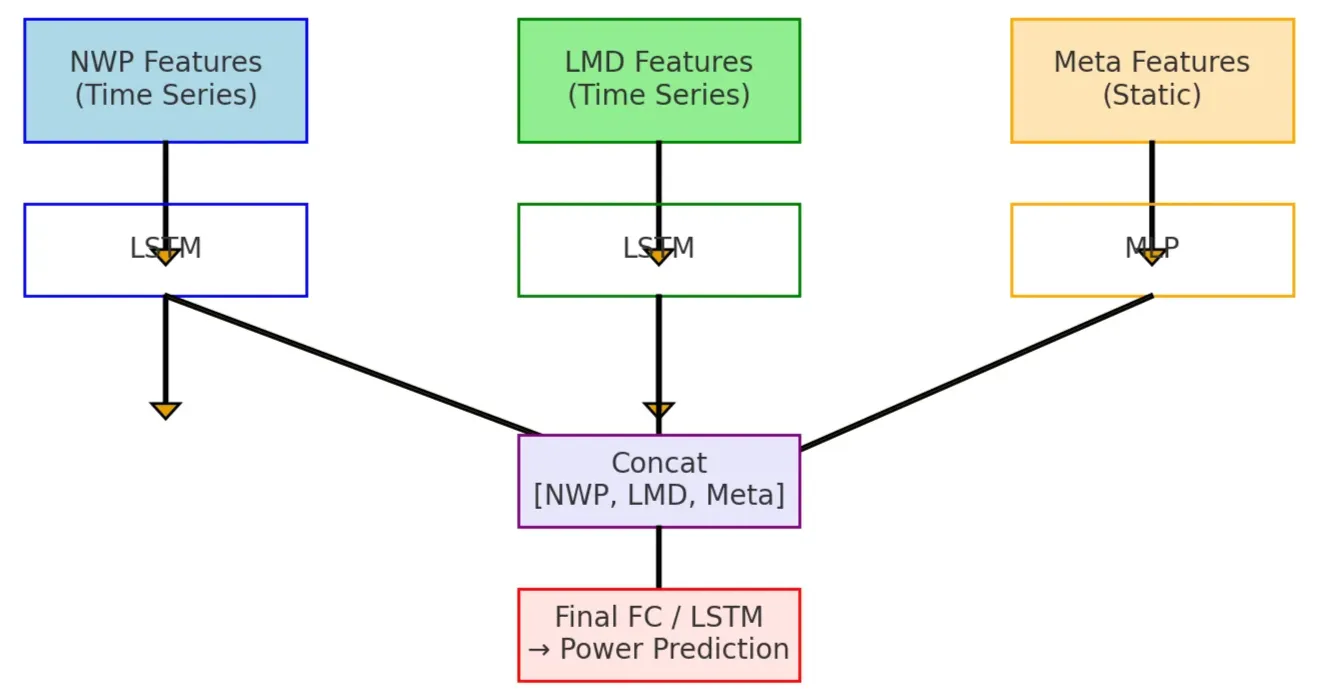

1. 텐서로 변환
2. Dataloader 생성
3. LSTM 생성
    - NWP - LSTM
    - LMD - LSTM
    - meta - MLP
    - 세 브랜치의 출력 벡터 concat
    - FC 레이어 혹은 LSTM으로 처리 -> power예측
4. 모델 학습 
    - 여러 발전소를 동시에 학습하여 공통 패턴과 발전소 특성을 함께 반영
    - 학습 시 station 데이터와 metadata 병합
5. 모델 성능 계산
    - 각 station 별 power 예측
    - MAE, RMSE, MAPE
6. validation
7. 모델 예측
    - test 데이터 사용
    - 각 station 별 power 예측

1. 모델 초기화

In [47]:
# 크기 확인
input_size  = torch_train_x.shape[-1] # 22
output_size = torch_train_y.shape[-1] if torch_train_y.dim() == 2 else 1
num_stations = len(station_to_idx)
num_layers = 2
meta_dim = torch_train_meta.shape[1] if 'torch_train_meta' in globals() and torch_train_meta is not None else 0
station_emb_dim = 8
dropout = 0.2
hidden_size = 128

LSTM = PVPlantLSTM(
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=output_size, # 1
    num_layers=num_layers,
    bidirectional=False,
    num_stations=num_stations,
    station_emb_dim=station_emb_dim,
    meta_dim=meta_dim,
    dropout=dropout
).to(device)
LSTM

PVPlantLSTM(
  (lstm): LSTM(22, 128, num_layers=2, batch_first=True, dropout=0.2)
  (st_emb): Embedding(10, 8)
  (head): Sequential(
    (0): Linear(in_features=156, out_features=78, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=78, out_features=4, bias=True)
  )
)

In [48]:
d_model = 128
nhead = 8
dim_feedforward = 512
num_ts_layers = 3

Transformer = PVPlantTransformer(
    input_size=input_size, # LSTM의 input_size와 동일
    d_model=d_model, # hidden_size
    output_size=output_size, # 예측 스텝 수
    num_layers=num_ts_layers, # 인코더 레이어 수
    num_stations=num_stations, # station 개수
    station_emb_dim=station_emb_dim, # station 임베딩 차원
    meta_dim=meta_dim, # 메타 피처 차원
    dropout=dropout, # 드롭아웃 비율
    nhead=nhead, # 멀티헤드 어텐션 헤드 수
    dim_feedforward=dim_feedforward, # 피드포워드 네트워크 차원
    max_len=input_window, # 최대 시퀀스 길이
    pool="last" 
).to(device)
Transformer

PVPlantTransformer(
  (embedding): TimeSeriesEmbedding(
    (input_proj): Linear(in_features=22, out_features=128, bias=True)
    (pos_encoder): PositionalEncoding()
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (enc_norm): 

In [49]:
# (x, y, s, meta) 튜플로 묶어서 DataLoader에 전달
train_ds = SeqDataset(torch_train_x, torch_train_y, torch_train_s, torch_train_meta if meta_dim>0 else None)
valid_ds = SeqDataset(torch_valid_x, torch_valid_y, torch_valid_s, torch_valid_meta if meta_dim>0 else None)
test_ds  = SeqDataset(torch_test_x,  torch_test_y,  torch_test_s,  torch_test_meta  if meta_dim>0 else None)

# DataLoader로 배치 사이즈에 맞춰 분할
batch_size = 512
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=torch.cuda.is_available())
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=torch.cuda.is_available())
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=torch.cuda.is_available())

In [50]:
model_list = [
    ('LSTM', LSTM),
    ('Transformer', Transformer)
]

In [51]:
for model_name, model in model_list:
    # 손실함수, 옵티마이저
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    num_epochs = 500
    best_loss = float('inf')
    best_path = f'results/best_{model_name}.pth'
    
    for epoch in range(1, num_epochs + 1):
        train_loss = train(train_loader, model, criterion, optimizer, device)
        valid_loss = evaluate(valid_loader, model, criterion, device)

        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model.state_dict(), best_path)
            print(f"[{model_name}] ({epoch:02d}) Saved best: valid {best_loss:.4f}")

        print(f"[{model_name}] ({epoch:02d}) train {train_loss:.4f} | valid {valid_loss:.4f}")

[LSTM] (01) Saved best: valid 0.0430
[LSTM] (01) train 0.0854 | valid 0.0430
[LSTM] (02) Saved best: valid 0.0415
[LSTM] (02) train 0.0381 | valid 0.0415
[LSTM] (03) Saved best: valid 0.0390
[LSTM] (03) train 0.0357 | valid 0.0390
[LSTM] (04) Saved best: valid 0.0389
[LSTM] (04) train 0.0342 | valid 0.0389
[LSTM] (05) train 0.0335 | valid 0.0389
[LSTM] (06) Saved best: valid 0.0373
[LSTM] (06) train 0.0330 | valid 0.0373
[LSTM] (07) train 0.0324 | valid 0.0377
[LSTM] (08) train 0.0321 | valid 0.0384
[LSTM] (09) train 0.0313 | valid 0.0397
[LSTM] (10) train 0.0310 | valid 0.0386
[LSTM] (11) train 0.0305 | valid 0.0382
[LSTM] (12) train 0.0299 | valid 0.0378
[LSTM] (13) train 0.0295 | valid 0.0395
[LSTM] (14) train 0.0289 | valid 0.0410
[LSTM] (15) train 0.0284 | valid 0.0410
[LSTM] (16) train 0.0278 | valid 0.0410
[LSTM] (17) train 0.0271 | valid 0.0423
[LSTM] (18) train 0.0266 | valid 0.0415
[LSTM] (19) train 0.0257 | valid 0.0431
[LSTM] (20) train 0.0252 | valid 0.0445
[LSTM] (21) tra

In [52]:
# valid의 평가 지표 계산
for model_name, model in model_list:
    best_path = f'results/best_{model_name}.pth'
    val_mae, val_rmse, val_mape = metrics(best_path, model, valid_loader, y_scaler, device)
    print(f"[Valid evaluation | {model_name}] Valid MAE: {val_mae:.4f}, RMSE: {val_rmse:.4f}, MAPE: {val_mape:.4f}")

[Valid evaluation | LSTM] Valid MAE: 0.5440, RMSE: 1.2909, MAPE: 5.9687
[Valid evaluation | Transformer] Valid MAE: 0.5621, RMSE: 1.3192, MAPE: 10.8252


### Test 데이터 평가

## 6. Deployment

- 발전소별 예측값 vs 실제값 시각화 